In [1]:
!pip install pytorch_lightning pytorch_forecasting==0.10.2 --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.0/719.0 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.7/140.7 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 308.2/308.2 kB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 829.5/829.5 kB 32.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 37.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 55.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 52.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.9/212.9 kB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.6/80.6 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 51.4 MB/s eta 0:00:00
     ━━━━━━━

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import copy
from pathlib import Path
import warnings

import numpy as np
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/TimeSeries/train.csv')

In [ ]:
train

,tag_1,tag_2,tag_3,tag_4,tag_5,tag_6,tag_7,tag_8,tag_9,tag_10,...,tag_26,tag_27,tag_28,tag_29,tag_30,tag_31,tag_32,tag_33,y,DTTM
0,-0.438928,0.363973,-4.365611,-1.568425,0.161162,0.044438,-2.395123,0.505856,-0.230406,0.493224,...,7.078086,0.265583,-0.052749,-0.212978,-0.818444,-0.161250,-0.052749,-0.129697,10.2,2019-12-20 02
1,-0.611069,-0.010479,-4.365611,-1.796646,0.073597,0.047305,-1.999617,0.500617,-1.112103,0.493224,...,5.858293,0.290568,-0.016350,-0.212978,-2.060946,-1.081893,-0.016350,-0.569841,10.1,2019-12-20 04
2,-0.443092,1.054543,-4.365611,-2.233180,0.111597,0.403096,-2.253642,0.504569,-0.929940,0.493224,...,6.283373,0.331822,-0.013720,-0.212978,-2.060828,-0.886434,-0.013720,-0.566221,9.4,2019-12-20 06
3,-0.388207,0.521133,-3.329981,-2.686685,0.114986,0.062529,-1.133890,0.504600,-0.490258,0.493224,...,7.079053,0.445680,-0.047419,-0.212978,-2.060924,-0.488113,-0.047419,-0.566478,10.4,2019-12-20 08
4,-0.330446,0.180247,-3.329981,-2.321764,0.091442,0.137555,-1.617280,0.512154,-0.571551,0.493224,...,6.623027,0.362849,-0.054553,-0.212978,-2.060642,-0.542389,-0.054553,-0.567719,9.4,2019-12-20 10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4990,1.152274,-0.738912,-3.329981,-1.944837,-0.105548,0.387550,0.583276,1.862913,0.269700,1.869432,...,-0.118363,0.377164,-0.272940,0.104645,-2.716452,-0.032827,-0.272940,-0.113933,8.9,2022-03-07 14
4991,1.076390,-0.657424,-3.329981,-1.806497,-0.103664,0.333036,0.095556,1.861150,0.179902,1.869432,...,-0.306155,0.506167,-0.276291,0.104645,-2.716266,-0.058737,-0.276291,-0.116089,9.3,2022-03-07 16
4992,0.997281,-0.653964,-3.329981,-2.114140,-0.098285,0.557389,-1.343931,1.859720,0.127092,1.869432,...,-0.341015,-0.161793,-0.269964,0.104645,-2.716173,-0.119851,-0.269964,-0.117202,9.9,2022-03-07 18
4993,0.964550,-0.577314,-3.329981,-1.479854,-0.057832,0.648608,-0.576991,1.863218,0.095384,1.869432,...,-0.179991,0.322301,-0.271108,0.104645,-2.715844,-0.162886,-0.271108,-0.113291,9.3,2022-03-07 20


In [ ]:
train = train.sort_values(by='DTTM').reset_index(drop=True)

In [ ]:
train['time_idx'] = train.index

In [ ]:
data = train

In [ ]:
data.columns

Index(['tag_1', 'tag_2', 'tag_3', 'tag_4', 'tag_5', 'tag_6', 'tag_7', 'tag_8',
       'tag_9', 'tag_10', 'tag_11', 'tag_12', 'tag_13', 'tag_14', 'tag_15',
       'tag_16', 'tag_17', 'tag_18', 'tag_19', 'tag_20', 'tag_21', 'tag_22',
       'tag_23', 'tag_24', 'tag_25', 'tag_26', 'tag_27', 'tag_28', 'tag_29',
       'tag_30', 'tag_31', 'tag_32', 'tag_33', 'y', 'DTTM', 'time_idx'],
      dtype='object')

In [ ]:
data

,tag_1,tag_2,tag_3,tag_4,tag_5,tag_6,tag_7,tag_8,tag_9,tag_10,...,tag_27,tag_28,tag_29,tag_30,tag_31,tag_32,tag_33,y,DTTM,time_idx
0,-0.438928,0.363973,-4.365611,-1.568425,0.161162,0.044438,-2.395123,0.505856,-0.230406,0.493224,...,0.265583,-0.052749,-0.212978,-0.818444,-0.161250,-0.052749,-0.129697,10.2,2019-12-20 02,0
1,-0.611069,-0.010479,-4.365611,-1.796646,0.073597,0.047305,-1.999617,0.500617,-1.112103,0.493224,...,0.290568,-0.016350,-0.212978,-2.060946,-1.081893,-0.016350,-0.569841,10.1,2019-12-20 04,1
2,-0.443092,1.054543,-4.365611,-2.233180,0.111597,0.403096,-2.253642,0.504569,-0.929940,0.493224,...,0.331822,-0.013720,-0.212978,-2.060828,-0.886434,-0.013720,-0.566221,9.4,2019-12-20 06,2
3,-0.388207,0.521133,-3.329981,-2.686685,0.114986,0.062529,-1.133890,0.504600,-0.490258,0.493224,...,0.445680,-0.047419,-0.212978,-2.060924,-0.488113,-0.047419,-0.566478,10.4,2019-12-20 08,3
4,-0.330446,0.180247,-3.329981,-2.321764,0.091442,0.137555,-1.617280,0.512154,-0.571551,0.493224,...,0.362849,-0.054553,-0.212978,-2.060642,-0.542389,-0.054553,-0.567719,9.4,2019-12-20 10,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4990,1.152274,-0.738912,-3.329981,-1.944837,-0.105548,0.387550,0.583276,1.862913,0.269700,1.869432,...,0.377164,-0.272940,0.104645,-2.716452,-0.032827,-0.272940,-0.113933,8.9,2022-03-07 14,4990
4991,1.076390,-0.657424,-3.329981,-1.806497,-0.103664,0.333036,0.095556,1.861150,0.179902,1.869432,...,0.506167,-0.276291,0.104645,-2.716266,-0.058737,-0.276291,-0.116089,9.3,2022-03-07 16,4991
4992,0.997281,-0.653964,-3.329981,-2.114140,-0.098285,0.557389,-1.343931,1.859720,0.127092,1.869432,...,-0.161793,-0.269964,0.104645,-2.716173,-0.119851,-0.269964,-0.117202,9.9,2022-03-07 18,4992
4993,0.964550,-0.577314,-3.329981,-1.479854,-0.057832,0.648608,-0.576991,1.863218,0.095384,1.869432,...,0.322301,-0.271108,0.104645,-2.715844,-0.162886,-0.271108,-0.113291,9.3,2022-03-07 20,4993


In [ ]:
target = 'y'
observed_variables = ['tag_1', 'tag_2', 'tag_3', 'tag_4', 'tag_5', 'tag_6', 'tag_7', 'tag_8',
       'tag_9', 'tag_10', 'tag_11', 'tag_12', 'tag_13', 'tag_14', 'tag_15',
       'tag_16', 'tag_17', 'tag_18', 'tag_19', 'tag_20', 'tag_21', 'tag_22',
       'tag_23', 'tag_24', 'tag_25', 'tag_26', 'tag_27', 'tag_28', 'tag_29',
       'tag_30', 'tag_31', 'tag_32', 'tag_33']  # PAST INPUTS

static = ['']
# known_variables = ['tag_1', 'tag_2', 'tag_3', 'tag_4', 'tag_5', 'tag_6', 'tag_7', 'tag_8',
#        'tag_9', 'tag_10', 'tag_11', 'tag_12', 'tag_13', 'tag_14', 'tag_15',
#        'tag_16', 'tag_17', 'tag_18', 'tag_19', 'tag_20', 'tag_21', 'tag_22',
#        'tag_23', 'tag_24', 'tag_25', 'tag_26', 'tag_27', 'tag_28', 'tag_29',
#        'tag_30', 'tag_31', 'tag_32', 'tag_33'] # KNOWN FUTURE INPUTS

data['group_key'] = 'none'

In [ ]:
data

,tag_1,tag_2,tag_3,tag_4,tag_5,tag_6,tag_7,tag_8,tag_9,tag_10,...,tag_28,tag_29,tag_30,tag_31,tag_32,tag_33,y,DTTM,time_idx,group_key
0,-0.438928,0.363973,-4.365611,-1.568425,0.161162,0.044438,-2.395123,0.505856,-0.230406,0.493224,...,-0.052749,-0.212978,-0.818444,-0.161250,-0.052749,-0.129697,10.2,2019-12-20 02,0,none
1,-0.611069,-0.010479,-4.365611,-1.796646,0.073597,0.047305,-1.999617,0.500617,-1.112103,0.493224,...,-0.016350,-0.212978,-2.060946,-1.081893,-0.016350,-0.569841,10.1,2019-12-20 04,1,none
2,-0.443092,1.054543,-4.365611,-2.233180,0.111597,0.403096,-2.253642,0.504569,-0.929940,0.493224,...,-0.013720,-0.212978,-2.060828,-0.886434,-0.013720,-0.566221,9.4,2019-12-20 06,2,none
3,-0.388207,0.521133,-3.329981,-2.686685,0.114986,0.062529,-1.133890,0.504600,-0.490258,0.493224,...,-0.047419,-0.212978,-2.060924,-0.488113,-0.047419,-0.566478,10.4,2019-12-20 08,3,none
4,-0.330446,0.180247,-3.329981,-2.321764,0.091442,0.137555,-1.617280,0.512154,-0.571551,0.493224,...,-0.054553,-0.212978,-2.060642,-0.542389,-0.054553,-0.567719,9.4,2019-12-20 10,4,none
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4990,1.152274,-0.738912,-3.329981,-1.944837,-0.105548,0.387550,0.583276,1.862913,0.269700,1.869432,...,-0.272940,0.104645,-2.716452,-0.032827,-0.272940,-0.113933,8.9,2022-03-07 14,4990,none
4991,1.076390,-0.657424,-3.329981,-1.806497,-0.103664,0.333036,0.095556,1.861150,0.179902,1.869432,...,-0.276291,0.104645,-2.716266,-0.058737,-0.276291,-0.116089,9.3,2022-03-07 16,4991,none
4992,0.997281,-0.653964,-3.329981,-2.114140,-0.098285,0.557389,-1.343931,1.859720,0.127092,1.869432,...,-0.269964,0.104645,-2.716173,-0.119851,-0.269964,-0.117202,9.9,2022-03-07 18,4992,none
4993,0.964550,-0.577314,-3.329981,-1.479854,-0.057832,0.648608,-0.576991,1.863218,0.095384,1.869432,...,-0.271108,0.104645,-2.715844,-0.162886,-0.271108,-0.113291,9.3,2022-03-07 20,4993,none


In [ ]:
max_prediction_length = 6 # 예측 타임 스텝
max_encoder_length = 12 # 예측에 사용할 입력 윈도우우
training_cutoff = data["time_idx"].max() - 1000

training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target=target,
    group_ids=["group_key"],
    min_encoder_length=max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    # static_categoricals=["agency", "sku"],
    # static_reals=["avg_population_2017", "avg_yearly_household_income_2017"],
    # time_varying_known_categoricals=["special_days", "month"],
    # variable_groups={"special_days": special_days},  # group of categorical variables can be treated as one variable
    time_varying_known_reals=observed_variables,
    # time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=[
        "y"
    ],
    # target_normalizer=GroupNormalizer(
    #     groups=["agency", "sku"], transformation="softplus"
    # ),  # use softplus and normalize by group
    add_relative_time_idx=True,
    add_target_scales=True, # static
    add_encoder_length=False, # static
)

# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series
validation = TimeSeriesDataSet.from_dataset(training, data[lambda x: x.time_idx > (training_cutoff + max_prediction_length)], predict=False, stop_randomization=True)

# create dataloaders for model
batch_size = 32  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=0)

In [ ]:
len(training)

4000

In [ ]:
# ## TEST CODE

# actuals = torch.cat([y for x, (y, weight) in iter(val_dataloader)])
# baseline_predictions = Baseline().predict(val_dataloader)
# (actuals - baseline_predictions).abs().mean().item()

In [ ]:
# actuals - baseline_predictions.abs()

In [ ]:
# configure network and trainer
pl.seed_everything(42)
trainer = pl.Trainer(
    gpus=0,
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,
    hidden_size=32,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=16,
    output_size=7,
    loss=QuantileLoss(),
    log_interval=2,
    reduce_on_plateau_patience=4
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

INFO:lightning_fabric.utilities.seed:Global seed set to 42
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:474: LightningDeprecationWarning: Setting `Trainer(gpus=0)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=0)` instead.
  rank_zero_deprecation(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/utilities/parsing.py:263: UserWarning

AttributeError: ignored

In [ ]:
res = trainer.tuner.lr_find(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

NameError: ignored

In [ ]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=10,
    gpus=0,
    enable_model_summary=True,
    gradient_clip_val=0.1,
    limit_train_batches=30,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=res.suggestion(),
    hidden_size=16,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=8,
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    reduce_on_plateau_patience=4,
    optimizer='adam'
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


NameError: ignored

In [ ]:
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

INFO:pytorch_lightning.callbacks.model_summary:
   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 592   
4  | static_variable_selection          | VariableSelectionNetwork        | 1.1 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 24.9 K
6  | decoder_variable_selection         | VariableSelectionNetwork        | 24.2 K
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | static_context_initial_cell_

Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/trainer.py:1558: PossibleUserWarning: The number of training batches (30) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


In [ ]:
## HyperParamter Tuning

import pickle

from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

# create study CAPTION: IT TOOK REALLY LONG TIME
# Optuna
study = optimize_hyperparameters(
    train_dataloader,
    val_dataloader,
    model_path="optuna_test",
    n_trials=500,
    max_epochs=1000,
    gradient_clip_val_range=(0.01, 1.0),
    hidden_size_range=(8, 512),
    hidden_continuous_size_range=(8, 512),
    attention_head_size_range=(1, 8),
    learning_rate_range=(0.001, 0.1),
    dropout_range=(0.1, 0.3),
    trainer_kwargs=dict(limit_train_batches=30),
    reduce_on_plateau_patience=4,
    use_learning_rate_finder=False,  # use Optuna to find ideal learning rate or use in-built learning rate finder
)

# save study results - also we can resume tuning at a later point in time
with open("test_study.pkl", "wb") as fout:
    pickle.dump(study, fout)

# show best hyperparameters
print(study.best_trial.params)

[I 2022-12-07 11:38:43,578] A new study created in memory with name: no-name-bf533f79-7aaa-4954-9a23-4e9627480beb
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=[0])` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=[0])` instead.
  rank_zero_deprecation(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['

{'gradient_clip_val': 0.32778348390519274, 'hidden_size': 11, 'dropout': 0.10721384607355391, 'hidden_continuous_size': 9, 'attention_head_size': 3, 'learning_rate': 0.03344292005682475}


In [ ]:
# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
# best_model_path = trainer.checkpoint_callback.best_model_path
# best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)
best_tft = tft

In [ ]:
# calcualte mean absolute error on validation set
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_tft.predict(val_dataloader)
(actuals - predictions).abs().mean()

tensor(nan)

In [ ]:
raw_predictions, x = best_tft.predict(val_dataloader, mode="raw", return_x=True)

/usr/local/lib/python3.8/dist-packages/pytorch_forecasting/models/base_model.py:92: UserWarning: Not all dimensions are equal for tensors shapes. Example tensor torch.Size([32, 6, 1, 12]). Returning list instead of torch.Tensor.
  warnings.warn(


In [ ]:
raw_predictions

Output(prediction=tensor([[[ 8.6201,  9.1250,  9.4097,  ..., 10.0951, 10.3985, 10.7840],
         [ 8.6962,  9.1917,  9.4340,  ..., 10.0566, 10.3650, 10.7387],
         [ 9.0689,  9.5807,  9.7863,  ..., 10.4022, 10.6684, 10.8718],
         [ 8.6178,  9.0916,  9.4377,  ..., 10.2022, 10.5291, 10.8414],
         [ 8.6205,  9.0414,  9.3411,  ..., 10.1006, 10.4160, 10.6904],
         [ 8.7505,  9.2768,  9.5799,  ..., 10.2647, 10.5877, 10.9003]],

        [[ 8.6813,  9.1695,  9.4090,  ..., 10.0124, 10.3203, 10.7183],
         [ 9.0571,  9.5667,  9.7710,  ..., 10.3778, 10.6443, 10.8622],
         [ 8.6063,  9.0763,  9.4224,  ..., 10.1804, 10.5083, 10.8318],
         [ 8.6153,  9.0318,  9.3310,  ..., 10.0846, 10.3999, 10.6799],
         [ 8.7408,  9.2631,  9.5681,  ..., 10.2497, 10.5752, 10.8932],
         [ 8.8656,  9.3802,  9.6492,  ..., 10.3240, 10.6302, 10.8890]],

        [[ 9.0941,  9.6179,  9.8308,  ..., 10.4169, 10.6761, 10.9065],
         [ 8.6282,  9.1138,  9.4728,  ..., 10.2215, 10.

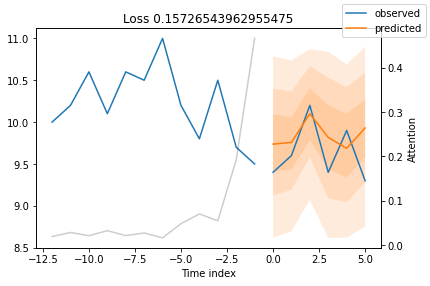

In [ ]:
best_tft.plot_prediction(x, raw_predictions, idx=0, add_loss_to_title=True);

In [ ]:
help(best_tft.plot_prediction)

Help on method plot_prediction in module pytorch_forecasting.models.temporal_fusion_transformer:

plot_prediction(x: Dict[str, torch.Tensor], out: Dict[str, torch.Tensor], idx: int, plot_attention: bool = True, add_loss_to_title: bool = False, show_future_observed: bool = True, ax=None, **kwargs) -> matplotlib.figure.Figure method of pytorch_forecasting.models.temporal_fusion_transformer.TemporalFusionTransformer instance
    Plot actuals vs prediction and attention
    
    Args:
        x (Dict[str, torch.Tensor]): network input
        out (Dict[str, torch.Tensor]): network output
        idx (int): sample index
        plot_attention: if to plot attention on secondary axis
        add_loss_to_title: if to add loss to title. Default to False.
        show_future_observed: if to show actuals for future. Defaults to True.
        ax: matplotlib axes to plot on
    
    Returns:
        plt.Figure: matplotlib figure



In [ ]:
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=0)

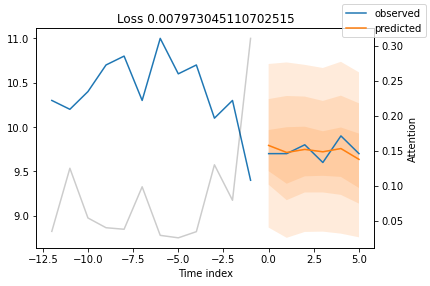

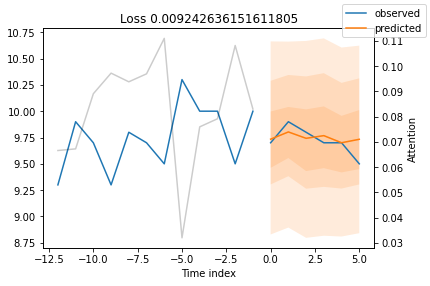

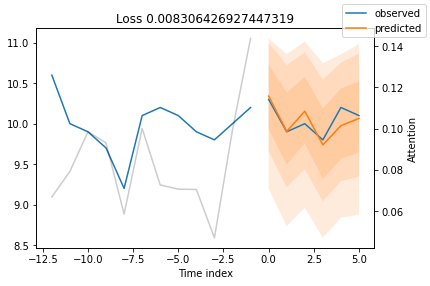

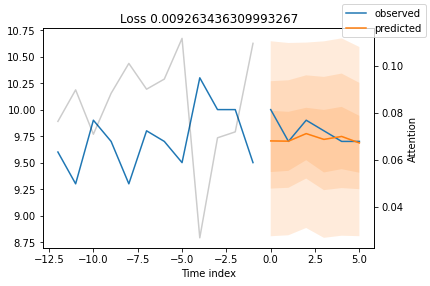

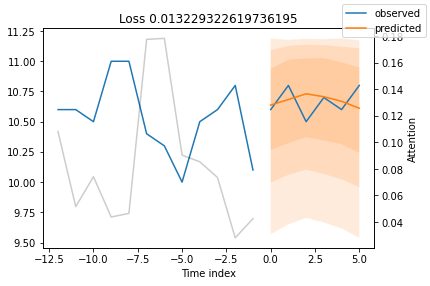

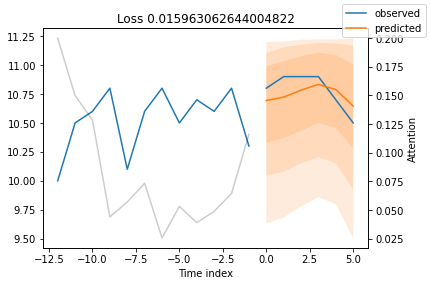

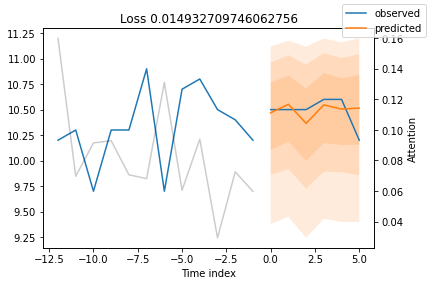

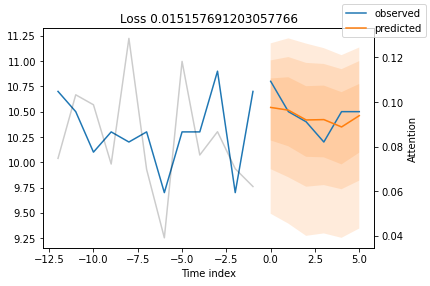

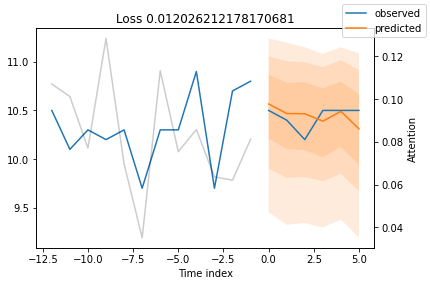

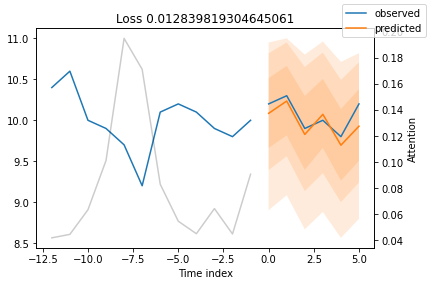

In [ ]:
predictions = best_tft.predict(val_dataloader)
mean_losses = SMAPE(reduction="none")(predictions, actuals).mean(1)
indices = mean_losses.argsort(descending=False)  # sort losses
for idx in range(10):  # plot 10 examples
    best_tft.plot_prediction(
        x, raw_predictions, idx=indices[idx], add_loss_to_title=SMAPE(quantiles=best_tft.loss.quantiles)
    );

/usr/local/lib/python3.8/dist-packages/pytorch_forecasting/models/base_model.py:1699: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  log_scale = scipy.stats.skew(values_actual) > 1.6
/usr/local/lib/python3.8/dist-packages/pytorch_forecasting/models/base_model.py:1699: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  log_scale = scipy.stats.skew(values_actual) > 1.6
/usr/local/lib/python3.8/dist-packages/pytorch_forecasting/models/base_model.py:1675: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(**

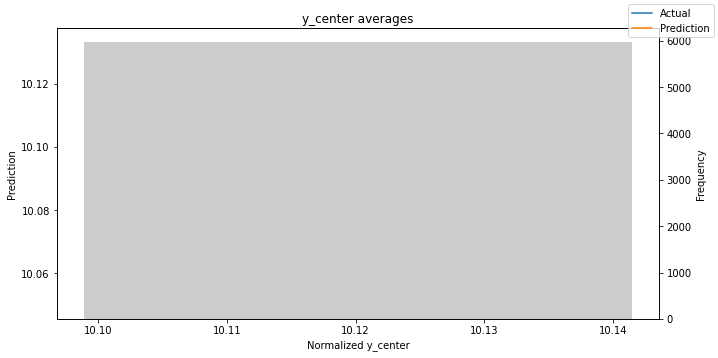

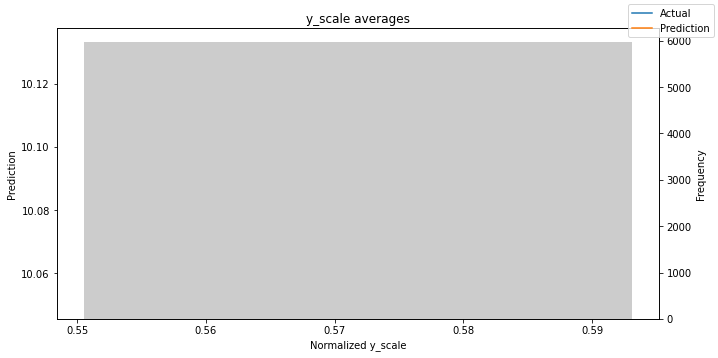

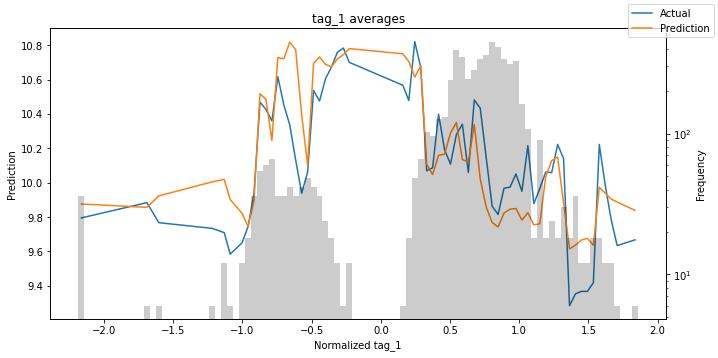

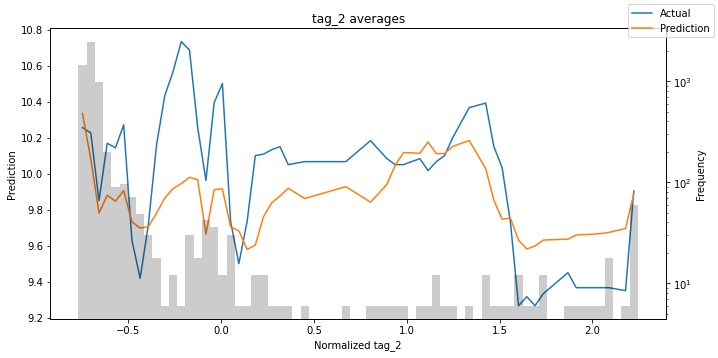

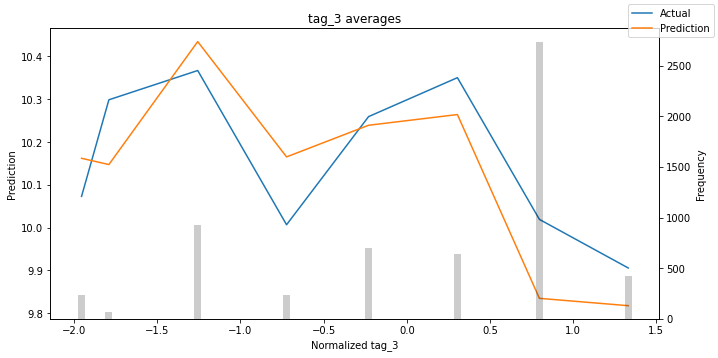

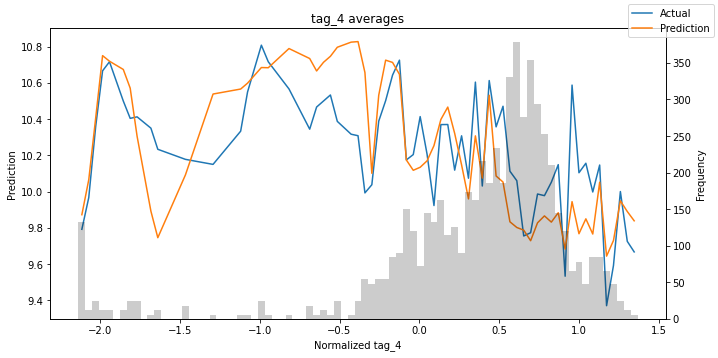

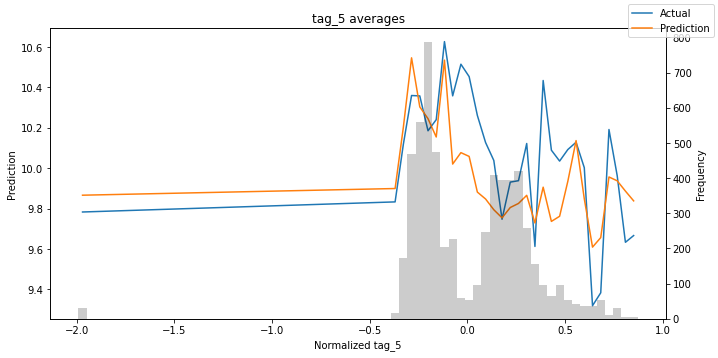

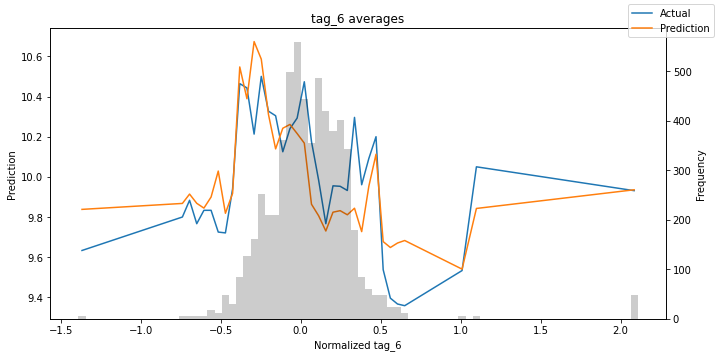

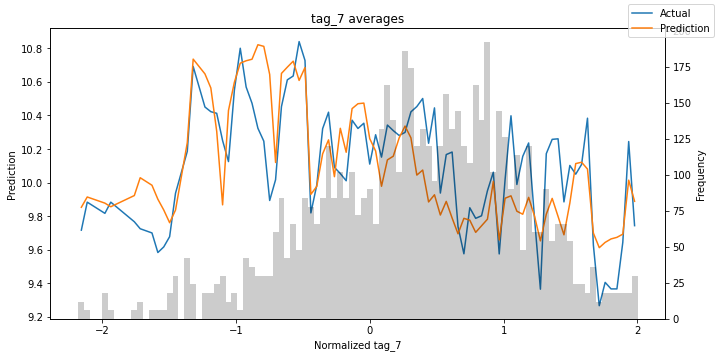

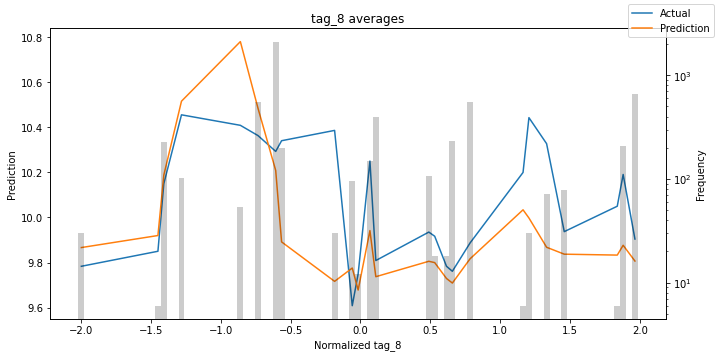

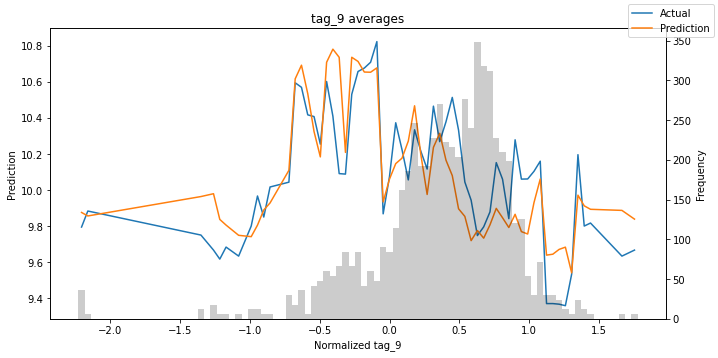

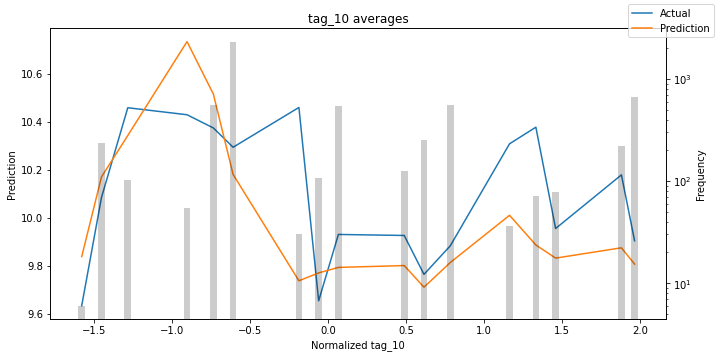

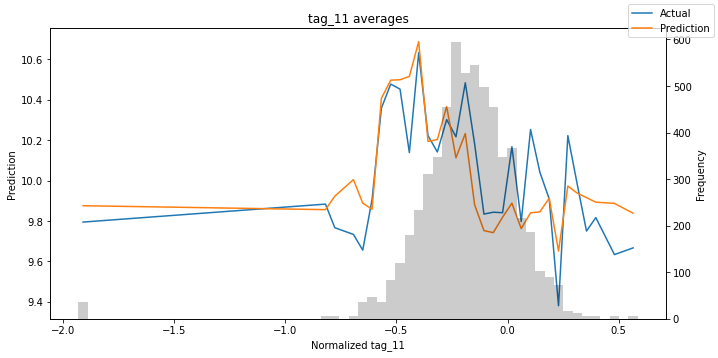

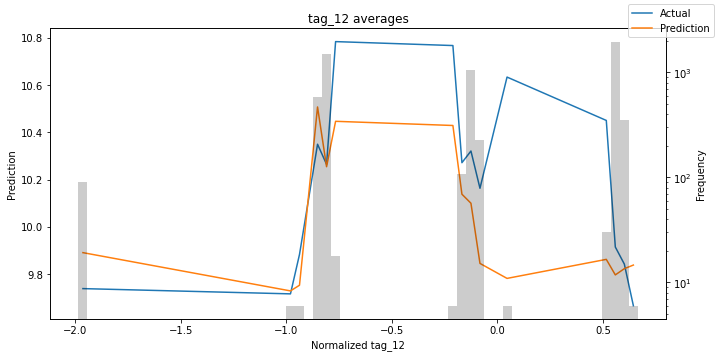

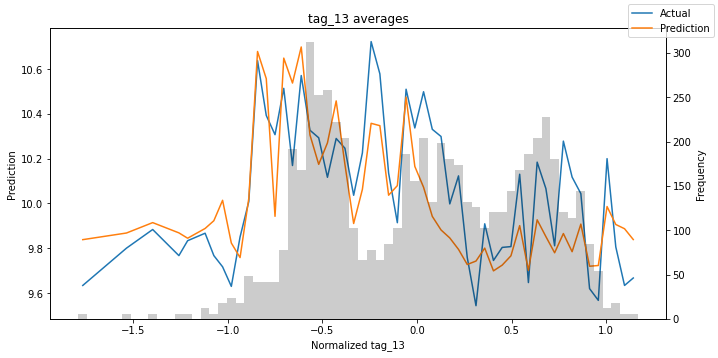

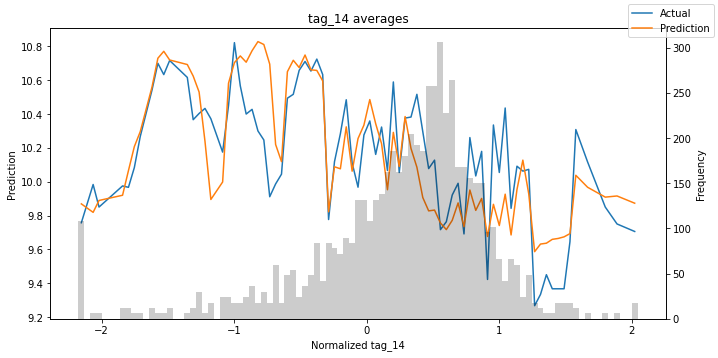

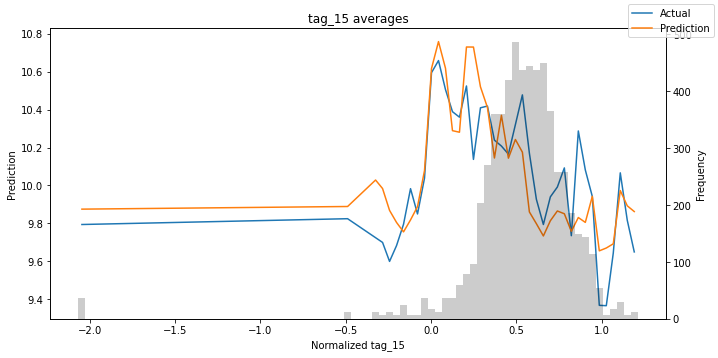

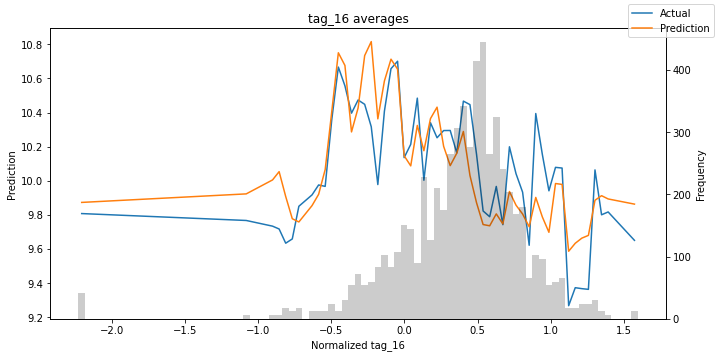

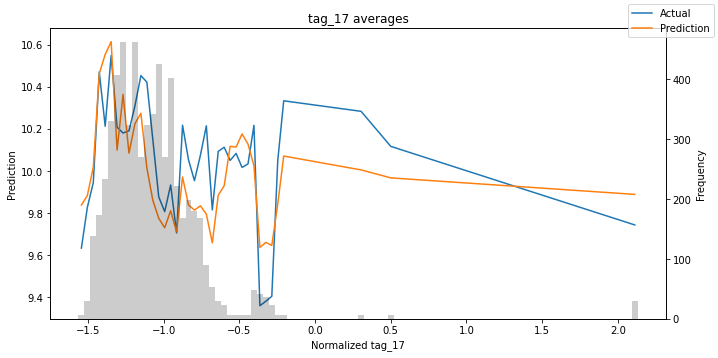

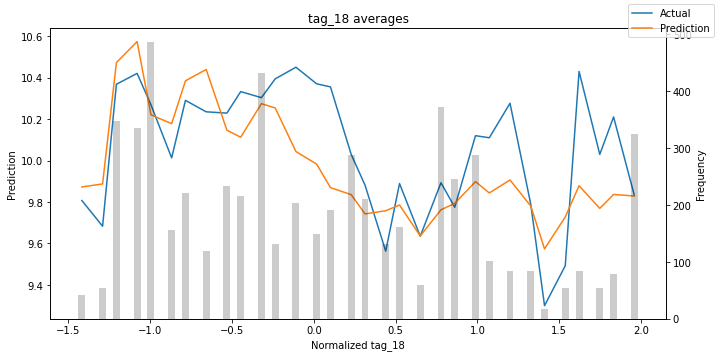

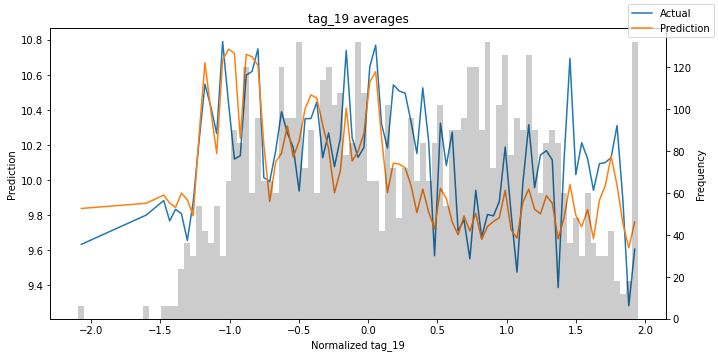

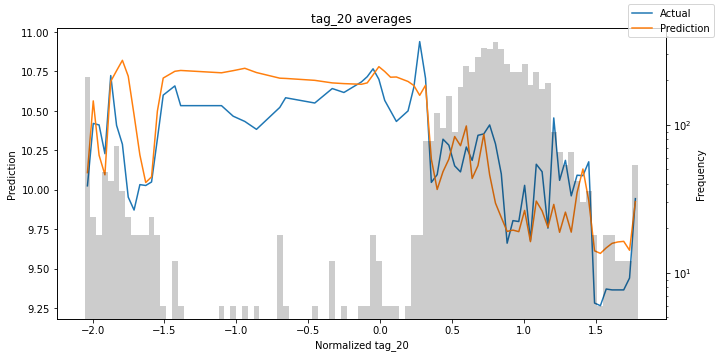

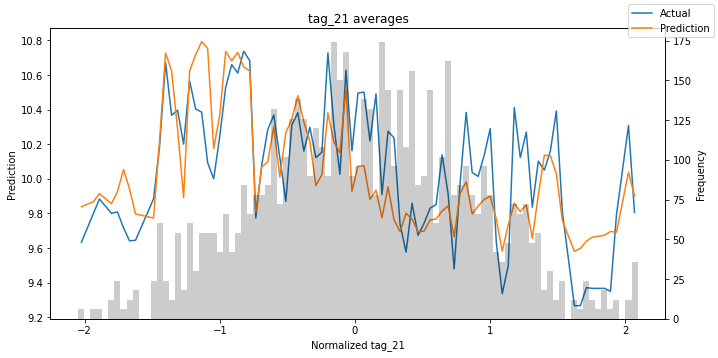

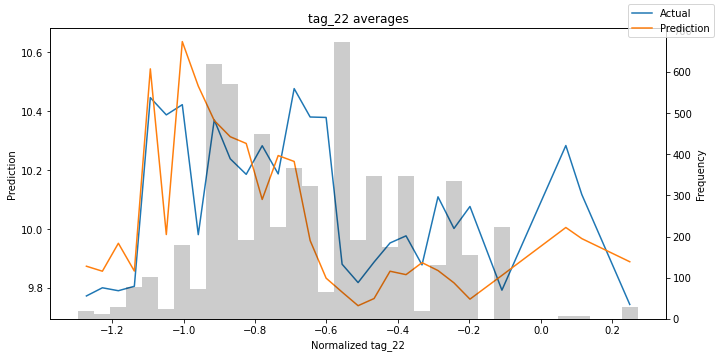

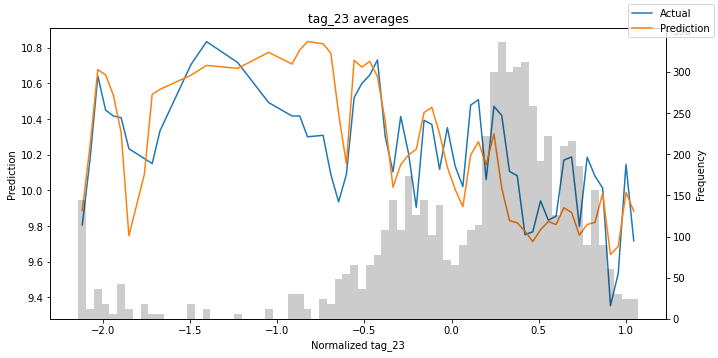

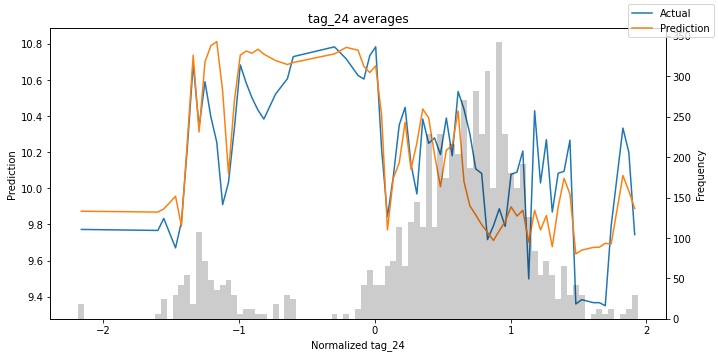

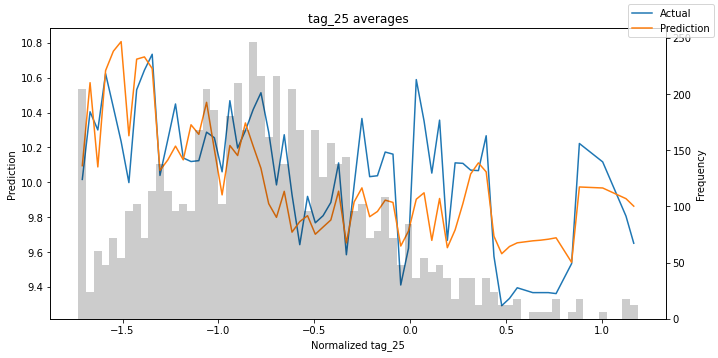

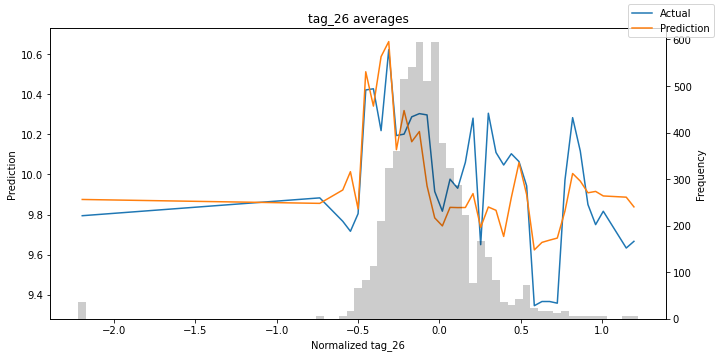

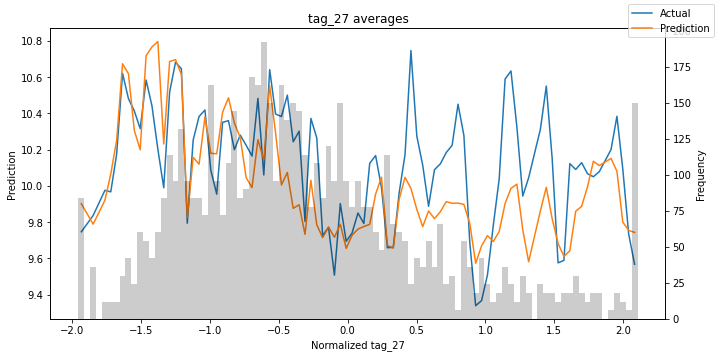

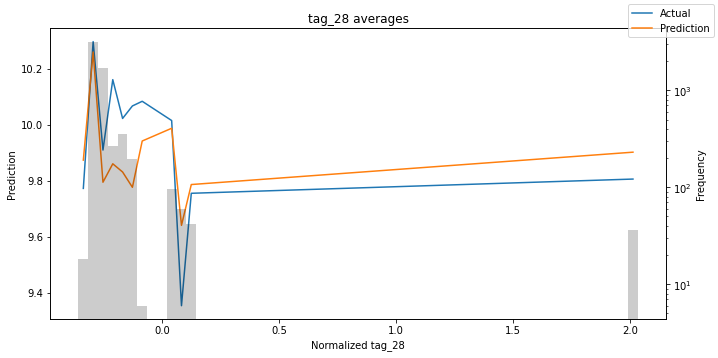

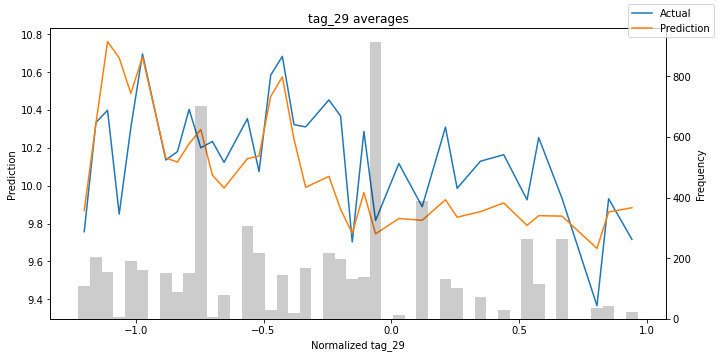

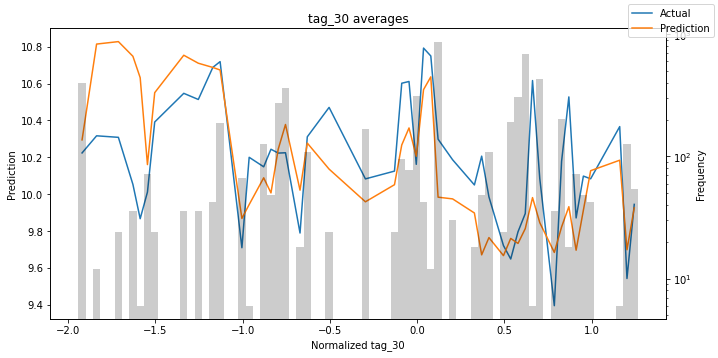

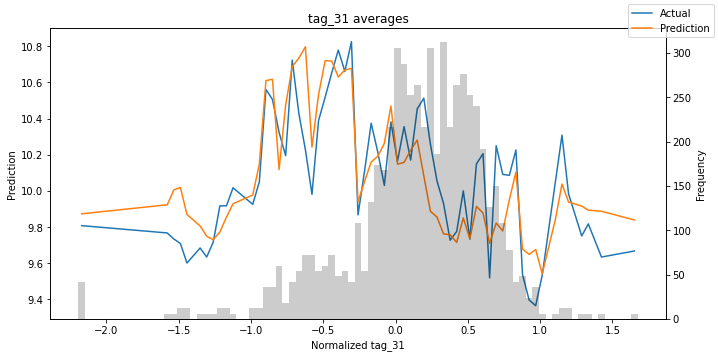

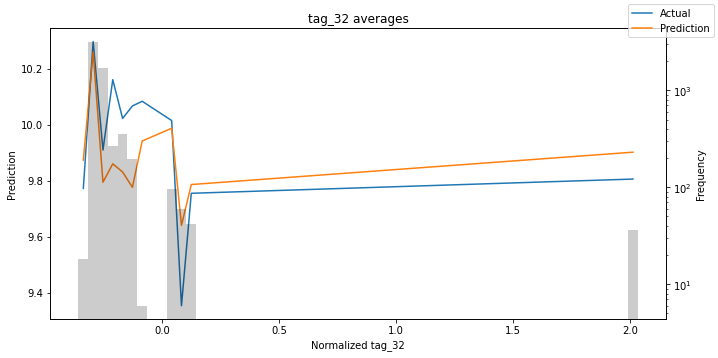

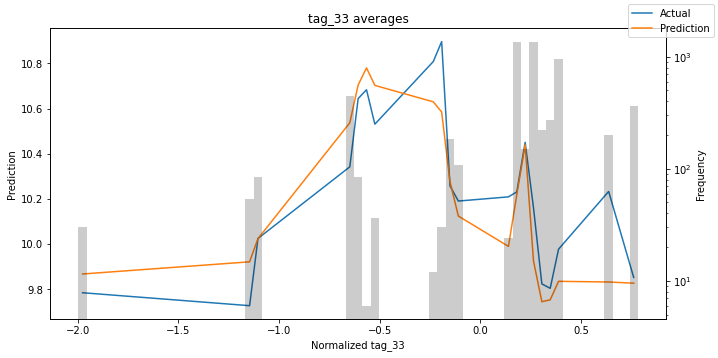

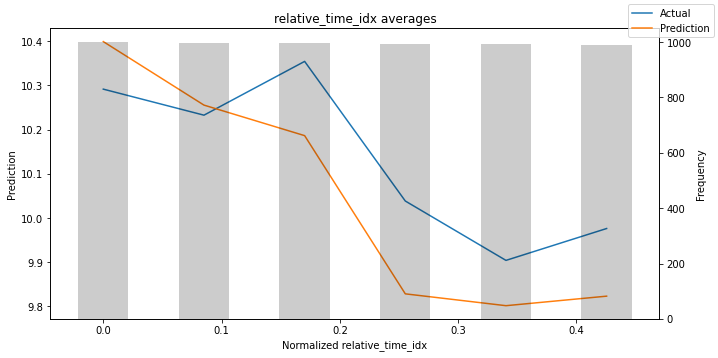

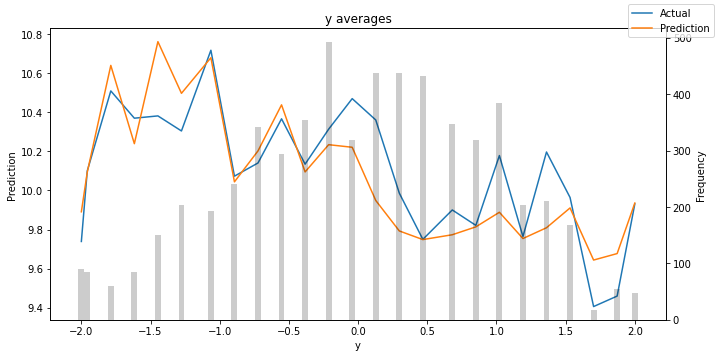

In [ ]:
predictions, x = best_tft.predict(val_dataloader, return_x=True)
predictions_vs_actuals = best_tft.calculate_prediction_actual_by_variable(x, predictions)
best_tft.plot_prediction_actual_by_variable(predictions_vs_actuals);

In [ ]:
# 1 x n_timesteps x n_quantiles = 1 x 6 x 7
best_tft.predict(
    training,
    mode="quantiles",
)

tensor([[[ 8.6910,  9.0789,  9.5636,  ..., 10.3231, 10.6496, 10.9126],
         [ 8.6912,  9.1074,  9.5476,  ..., 10.3598, 10.6693, 10.9732],
         [ 8.6777,  9.0813,  9.5321,  ..., 10.3360, 10.6575, 10.9395],
         [ 8.6300,  9.0296,  9.4547,  ..., 10.2288, 10.5593, 10.8411],
         [ 8.5765,  8.9650,  9.3519,  ..., 10.0935, 10.4327, 10.7471],
         [ 8.6368,  9.0525,  9.4458,  ..., 10.2584, 10.5870, 10.9097]],

        [[ 8.7129,  9.1140,  9.5866,  ..., 10.3858, 10.6936, 10.9908],
         [ 8.6939,  9.0923,  9.5609,  ..., 10.3589, 10.6800, 10.9568],
         [ 8.6438,  9.0435,  9.4806,  ..., 10.2500, 10.5818, 10.8595],
         [ 8.5871,  8.9782,  9.3743,  ..., 10.1116, 10.4534, 10.7644],
         [ 8.6456,  9.0640,  9.4621,  ..., 10.2739, 10.6041, 10.9246],
         [ 8.5779,  8.9704,  9.3405,  ..., 10.0764, 10.4073, 10.7203]],

        [[ 8.6980,  9.0797,  9.5701,  ..., 10.3545, 10.6765, 10.9552],
         [ 8.6529,  9.0425,  9.4933,  ..., 10.2510, 10.5817, 10.8602],
  

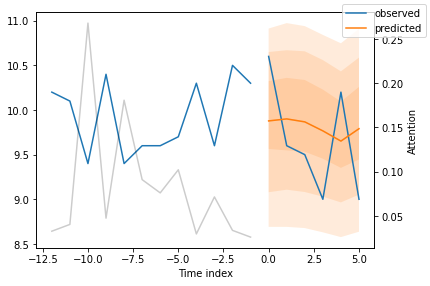

In [ ]:
raw_prediction, x = best_tft.predict(
    training,
    mode="raw",
    return_x=True,
)
best_tft.plot_prediction(x, raw_prediction, idx=0);

In [ ]:
help(best_tft.interpret_output)

Help on method interpret_output in module pytorch_forecasting.models.temporal_fusion_transformer:

interpret_output(out: Dict[str, torch.Tensor], reduction: str = 'none', attention_prediction_horizon: int = 0) -> Dict[str, torch.Tensor] method of pytorch_forecasting.models.temporal_fusion_transformer.TemporalFusionTransformer instance
    interpret output of model
    
    Args:
        out: output as produced by ``forward()``
        reduction: "none" for no averaging over batches, "sum" for summing attentions, "mean" for
            normalizing by encode lengths
        attention_prediction_horizon: which prediction horizon to use for attention
    
    Returns:
        interpretations that can be plotted with ``plot_interpretation()``



{'attention': <Figure size 432x288 with 1 Axes>,
 'static_variables': <Figure size 504x180 with 1 Axes>,
 'encoder_variables': <Figure size 504x774 with 1 Axes>,
 'decoder_variables': <Figure size 504x756 with 1 Axes>}

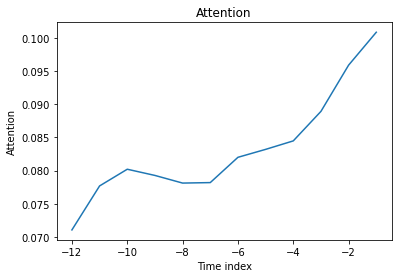

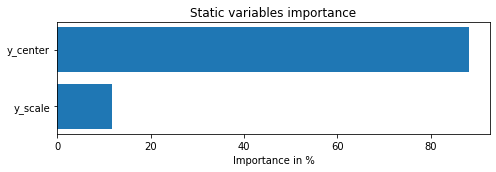

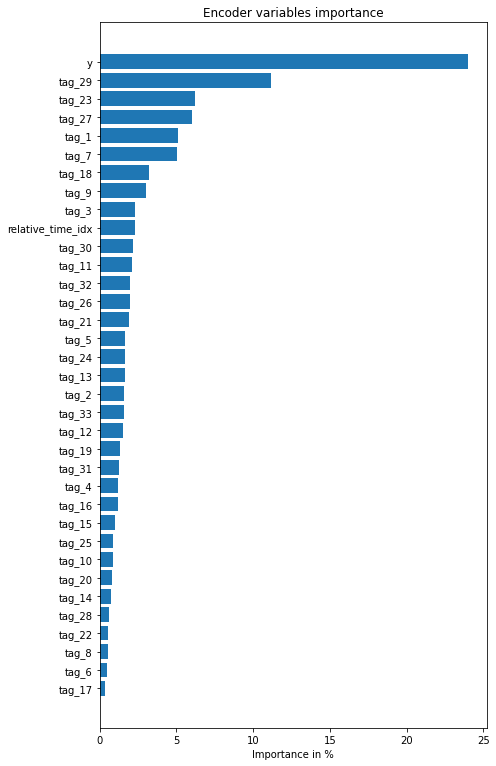

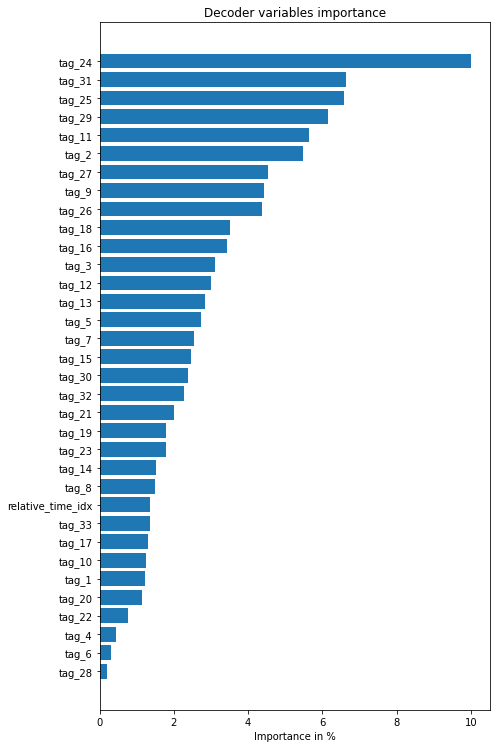

In [ ]:
interpretation = best_tft.interpret_output(raw_predictions, reduction="sum")
best_tft.plot_interpretation(interpretation)